# LSTM binary classification

### Importing des dependences

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.optimizers import  SGD
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence


from tensorflow.keras.utils import to_categorical
from keras import regularizers
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt

import os

### Importation du dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/database_apology_detection_v2.csv', usecols=['response', 'sorry_aspect'])

Visualizing du dataset :

In [ ]:
data.sorry_aspect.value_counts()

1    108
0    105
Name: sorry_aspect, dtype: int64

In [ ]:
X=data["response"]
Y=data["sorry_aspect"].astype(int)

In [ ]:
X

0      Thank you for your feedback! We're delighted t...
1      We're sorry to hear that your experience fell ...
2      We apologize for any inconvenience you may hav...
3      Thank you for taking the time to share your th...
4      We're truly sorry to hear that your visit did ...
                             ...                        
208    We appreciate your positive review! We strive ...
209    We apologize for any inconvenience you faced d...
210    Your positive feedback motivates us to keep de...
211    We're sorry for any inconvenience during your ...
212    Thank you for your positive review! We're thri...
Name: response, Length: 213, dtype: object

In [ ]:
Y


0      0
1      1
2      1
3      0
4      1
      ..
208    0
209    1
210    0
211    1
212    0
Name: sorry_aspect, Length: 213, dtype: int64

### Preprocessing

Nous avons tester plusieurs techniques de preprocessing : supression des stops words, lemmitization, stemming mais cela n'a pas induit une meilleur classification. Nous nous limiterons a la suppression de la ponctuation pour cette version

In [ ]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation.lower())
    return txt
X=[clean_text(i) for i in X]

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

def get_sequence_of_tokens(corpus):

    ## total_words : le nombre maximal de mots dans le vocabulaire de notre models
    total_words = len(tokenizer.word_index) + 1

    ## conversion de la dataset en sequences de tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(X)

In [ ]:
# Ajout d'un padding aux sequences pour les homogeniser a une seul longeur
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='post'))

    # Note : la fonction pad_sequences rajoute toujours une collumn de trop pour des raisons que j'ignore c'est pour cela que je vais la supprimer :
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

### Decoupage du dataset
On prendra seulement 10% pour la validation a cause de la taille reduite de la dataset.

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(predictors,Y, test_size=0.10, random_state=42)
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

### Architecture du modele

In [ ]:
def build_model():

  opt = Adam(learning_rate=0.01)

  model = Sequential()
  model.add(Embedding(total_words, 16, input_length=x_train.shape[1], mask_zero=True))
  model.add(LSTM(12, dropout=0.7, recurrent_dropout=0.7))
  model.add(Dense(6, kernel_regularizer=regularizers.l1_l2(0.3)))
  model.add(Dropout(0.8))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

model_lstm=build_model()

In [ ]:

history_lstm = model_lstm.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=8,
    validation_data=(x_test, y_test),
    shuffle=False,
    callbacks=[EarlyStopping(monitor='accuracy', mode='max', patience=7)])

Epoch 1/30
24/24 [==============================] - 7s 70ms/step - loss: 5.0523 - accuracy: 0.5445 - val_loss: 2.8809 - val_accuracy: 0.9545
Epoch 2/30
24/24 [==============================] - 1s 52ms/step - loss: 1.7718 - accuracy: 0.8534 - val_loss: 0.9916 - val_accuracy: 1.0000
Epoch 3/30
24/24 [==============================] - 1s 47ms/step - loss: 0.8277 - accuracy: 0.7277 - val_loss: 0.7396 - val_accuracy: 1.0000
Epoch 4/30
24/24 [==============================] - 1s 45ms/step - loss: 0.7413 - accuracy: 0.7068 - val_loss: 0.7093 - val_accuracy: 1.0000
Epoch 5/30
24/24 [==============================] - 1s 43ms/step - loss: 0.7229 - accuracy: 0.7592 - val_loss: 0.7067 - val_accuracy: 1.0000
Epoch 6/30
24/24 [==============================] - 1s 46ms/step - loss: 0.7427 - accuracy: 0.7068 - val_loss: 0.6981 - val_accuracy: 0.9545
Epoch 7/30
24/24 [==============================] - 1s 60ms/step - loss: 0.6973 - accuracy: 0.8010 - val_loss: 0.6464 - val_accuracy: 1.0000
Epoch 8/30
24

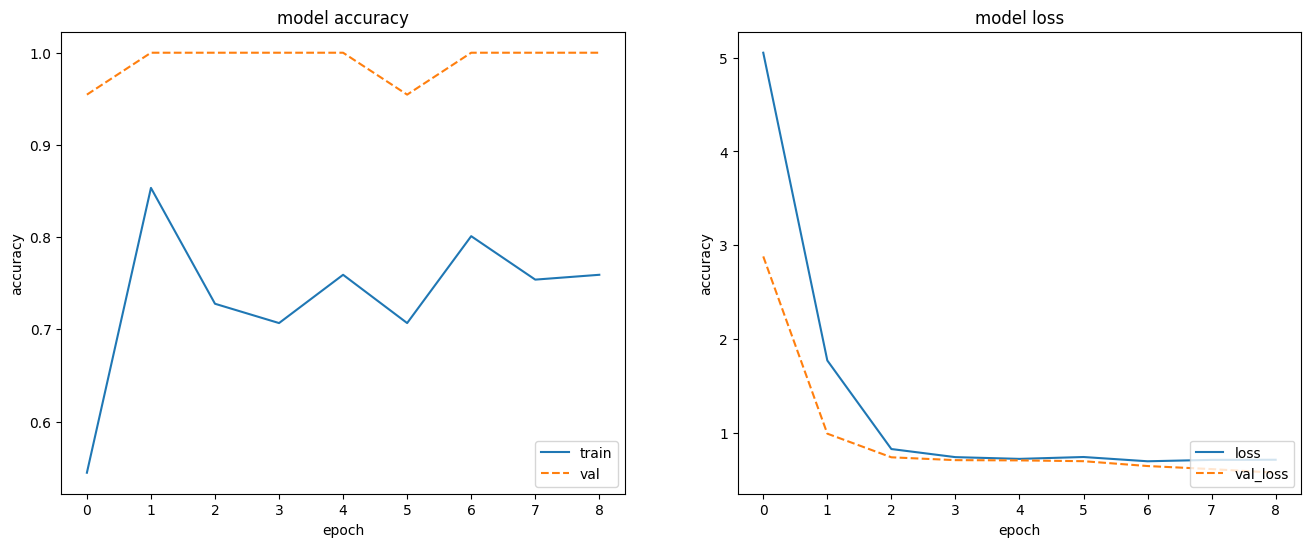

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_lstm.history['accuracy'])
axes[0].plot(history_lstm.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_lstm.history['loss'])
axes[1].plot(history_lstm.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['loss', 'val_loss'], loc='lower right')

## Save the model

In [ ]:
model_lstm.save('/content/drive/MyDrive/LSTM_apology_detection.keras')

# **TEST**

### importation du modele :

In [ ]:
from keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/LSTM_apology_detection.keras')

### test de predictions

In [ ]:
APOLOGY_THRESHOLD = 0.72
def predict(input):
    data = {"response":[f"{input}"]}
    test = pd.DataFrame(data)

    max_words = 341
    max_len = 41

    tok = Tokenizer(num_words=max_words)
    tok.fit_on_texts(test["response"])
    sequences = tok.texts_to_sequences(test["response"])
    txts = sequence.pad_sequences(sequences, maxlen=max_len, padding='post')
    preds = loaded_model.predict(txts)
    preds_=[ "apology" if APOLOGY_THRESHOLD<j else "no apology" for i,j in preds ]
    return preds_[0]

In [ ]:
print(predict("We apologize for this incident, we promise you a better experience on your next visit."))
print(predict("Your positive feedback motivates us to keep delivering exceptional service!"))
print(predict("We're sorry for any inconvenience during your recent interaction with our service."))
print(predict("Thank you for your positive review!"))
print(predict("Your feedback is essential to us! We're sorry if your recent experience didn't meet your expectations."))
print(predict("We're grateful for your kind words and look forward to creating more memorable experiences with you."))


1/1 [==============================] - 0s 27ms/step
apology
1/1 [==============================] - 0s 26ms/step
no apology
1/1 [==============================] - 0s 25ms/step
apology
1/1 [==============================] - 0s 29ms/step
no apology
1/1 [==============================] - 0s 37ms/step
apology
1/1 [==============================] - 0s 25ms/step
no apology
